Positive rate: 0.5547445255474452
F1-score 0.9868995633187774


(0.0, 4.5)

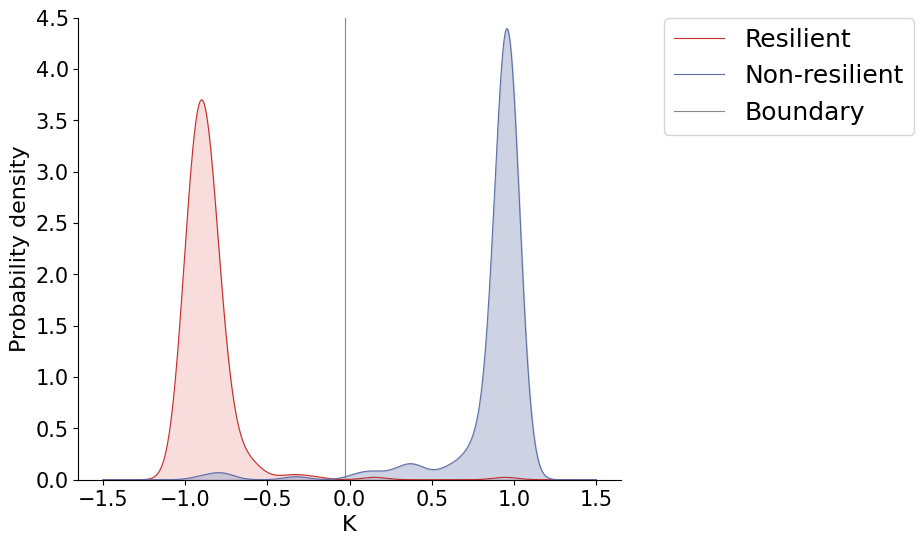

In [1]:
import torch
import numpy as np
import sys
sys.path.append('..')
import matplotlib
import matplotlib.pyplot as plt
from model.resinf import ResInf
import argparse
from tqdm import tqdm
from torch.utils.data import DataLoader
from demo_utils import *
from sklearn.neighbors import KernelDensity
from matplotlib.legend_handler import HandlerBase

parser = argparse.ArgumentParser('ResInf Demo')
parser.add_argument('--method', type=str,
                    choices=['dopri5', 'adams', 'explicit_adams', 'fixed_adams','tsit5', 'euler', 'midpoint', 'rk4'],
                    default='euler')  # dopri5
parser.add_argument('--rtol', type=float, default=0.01,
                    help='optional float64 Tensor specifying an upper bound on relative error, per element of y')
parser.add_argument('--atol', type=float, default=0.001,
                    help='optional float64 Tensor specifying an upper bound on absolute error, per element of y')
parser.add_argument('--lr', type=float, default=0.001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=1e-5,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--hidden', type=int, default=6,
                    help='Number of hidden units.')
parser.add_argument('--epoch', type=int, default=35)
parser.add_argument('--train_size', type=int, default=1)
parser.add_argument('--valid_size', type=int, default=1)
parser.add_argument('--test_size', type=int, default=1)
parser.add_argument('--layers', type=int, default=3)
parser.add_argument('--type', type=str, default='node')
parser.add_argument('--K', type=int, default=10)
parser.add_argument('--comment', type=str, default='normal')
parser.add_argument('--mech', type=int, default=1)
parser.add_argument('--use_model',type=str, default='resinf')
parser.add_argument('--load',type=int, default=0)
parser.add_argument('--emb_size',type=int,default=8)
parser.add_argument('--hidden_layers_num', type=int, default=1)
parser.add_argument('--pool_type', type=str, default='virtual')
parser.add_argument('--pool_arch', type=str, default='global')
parser.add_argument('--trans_layers', type=int, default=1)
parser.add_argument('--trans_emb_size',type=int, default=32)
parser.add_argument('--n_heads',type=int, default=4)
parser.add_argument('--gpu', type=int, default=2)

args = parser.parse_args(args=['--type', 'all', '--gpu', '2', '--load', '1'])
if args.gpu >= 0:
    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

model = ResInf(input_plane=args.K, seq_len = args.hidden, trans_layers=args.trans_layers, gcn_layers=args.layers, hidden_layers=args.hidden_layers_num, gcn_emb_size=args.emb_size, trans_emb_size=args.trans_emb_size, pool_type=args.pool_type, args=args,n_heads=args.n_heads).to(device)
model.load_state_dict(torch.load('utils/ckpt.pth'))

if args.load == 0:
    seed = np.random.randint(0, 100000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    dataset = NetDataset()
    train_length = int(len(dataset) * 0.8)
    valid_length = int(len(dataset) * 0.1)
    test_length = len(dataset) - train_length - valid_length

    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_length, valid_length, test_length])
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    t_test = tqdm(test_loader,smoothing=0, mininterval=1.0)
    high_dim_vecs = torch.zeros(1,1).to(device)
    all_count = 0
    yes_count = 0
    preds = []
    truths = []
    all_data_loader = DataLoader(dataset, batch_size=1)
    t_test = tqdm(test_loader,smoothing=0, mininterval=1.0)
    with torch.no_grad():
        for i, (A, numericals, r_truth, r_base) in enumerate(t_test):
            A = A.numpy()
            numericals = numericals.numpy()
            A = A.squeeze(0)
            numericals = numericals.squeeze(0)
            all_count += 1
            check = np.any(np.array(A))
            if not check:
                continue
            A, numericals, r_truth, r_base = process_instance(A, numericals, r_truth, r_base, args)
            if args.mech == 1:
                numericals_use = numericals.index_select(0, torch.tensor(random.choices(list(range(11)), k=args.K)).to(device))
            elif args.mech == 2 or args.mech == 3:
                numericals_use = numericals.index_select(0, torch.tensor(random.choices(list(range(5)), k=args.K)).to(device))
            r_pred, high_dim_vec, _= model(numericals_use[:,:,1:1+args.hidden], A)
            if not torch.isnan(r_pred):
                high_dim_vec = high_dim_vec.contiguous().view(1, -1)
                high_dim_vecs = torch.cat([high_dim_vecs, high_dim_vec], dim=0)
                preds.append(round(r_pred.item()))
                truths.append(r_truth.item())

        high_dim_vecs = high_dim_vecs.detach().cpu().numpy()
        high_dim_vecs = np.array(high_dim_vecs)
        high_dim_vecs = high_dim_vecs[1:]
        one_dim_vecs = high_dim_vecs

        with open('utils/one_dim_vecs.npy'.format(args.mech), 'wb') as f:
            np.save(f, one_dim_vecs)
        with open('utils/truths.npy'.format(args.mech), 'wb') as f:
            np.save(f, truths)
        with open('utils/preds.npy'.format(args.mech), 'wb') as f:
            np.save(f, preds)

elif args.load == 1:
    one_dim_vecs = np.load(open('./utils/one_dim_vecs_demo.npy'.format(args.mech), 'rb'))
    truths = np.load(open('./utils/truths_demo.npy'.format(args.mech), 'rb'))
    preds = np.load(open('./utils/preds_demo.npy'.format(args.mech), 'rb'))

print('Positive rate:', np.array(truths).sum()/len(truths))
from sklearn import metrics
acc = metrics.accuracy_score(truths, preds)
f1 = metrics.f1_score(truths, preds)
print('F1-score', f1)
nd_truths = np.array(truths)
label1 = np.where(nd_truths==0.0)[0]
label2 = np.nonzero(nd_truths)[0]
x_neg = one_dim_vecs[label1]
x_pos = one_dim_vecs[label2]
plt.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'axes.labelsize': 'x-large',
                    })
# plt.rcParams['font.sans-serif'] = ['Arial']

fig,ax = plt.subplots(figsize=(7,6))
plt.rcParams.update({'pdf.fonttype':42,'ps.fonttype':42})
bandwith=0.15
x_plot = np.linspace(-1.5, 1.5, 1000)[:, np.newaxis]
kde1 = KernelDensity(bandwidth=0.075).fit(x_pos)
kde0 = KernelDensity(bandwidth=0.075).fit(x_neg)
plt.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 
                    })
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams.update({'pdf.fonttype':42,'ps.fonttype':42})
ax.plot(x_plot[:,0], np.exp(kde1.score_samples(x_plot)),label='Resilient',linewidth=0.8,color='#C22D2C')
ax.fill_between(x_plot[:,0],0,np.exp(kde1.score_samples(x_plot)),alpha=0.5,color='#F4BCBB')
ax.plot(x_plot[:,0],np.exp(kde0.score_samples(x_plot)), label='Non-resilient',linewidth=0.8,color='#5E6FA6')
ax.fill_between(x_plot[:,0],0,np.exp(kde0.score_samples(x_plot)),alpha=0.5,color='#9EA8CA')
boundary = ((0-model.pred_linear.bias)/model.pred_linear.weight).item()
ax.axvline(x = boundary,label='Boundary',color='#8C8888',linewidth=0.8,linestyle='solid')
ax.legend(bbox_to_anchor=(1.54,1), borderaxespad=0,fontsize=18)
ax.set_xlabel('K',fontsize=16)
ax.set_ylabel('Probability density', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, 4.5])